In [1]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
from monai.transforms import LoadImage, Activations, AsDiscrete, EnsureChannelFirst
from monai.data import Dataset, DataLoader

image_dir = "/cluster/projects/vc/data/mic/open/OCELOT/ocelot_data/images"
label_dir = "/cluster/projects/vc/data/mic/open/OCELOT/ocelot_data/annotations"

directiories = ["train", "val", "test"]
number = 1

/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def collect_pairs(split):
    print("Current Split: ", split)
    img_tissues = sorted(glob(os.path.join(image_dir, split, "tissue", "*.jpg")))
    img_cells = sorted(glob(os.path.join(image_dir, split, "cell", "*.jpg")))

    label_tissues = sorted(glob(os.path.join(label_dir, split, "tissue", "*.png")))
    label_cropped_tissues = sorted(
        glob(os.path.join(label_dir, split, "cropped_tissue", "*.png"))
    )
    label_cell_masks = sorted(
        glob(os.path.join(label_dir, split, "cell_mask_images", "*.png"))
    )
    label_cells = sorted(glob(os.path.join(label_dir, split, "cell", "*.csv")))

    print("Number of img_tissues: ", len(img_tissues))
    print("Number of img_cells: ", len(img_cells))
    print("Number of label_tissues: ", len(label_tissues))
    print("Number of label_cropped_tissues: ", len(label_cropped_tissues))
    print("Number of label_cell_masks: ", len(label_cell_masks))
    print("Number of label_cells: ", len(label_cells))

    return [
        {
            "img_tissue": i_t,
            "img_cells": i_c,
            "label_tissues": l_t,
            "label_cropped_tissues": l_ct,
            "label_cell_masks": l_cm,
            "label_cells": l_c,
        }
        for i_t, i_c, l_t, l_ct, l_cm, l_c in zip(
            img_tissues,
            img_cells,
            label_tissues,
            label_cropped_tissues,
            label_cell_masks,
            label_cells,
        )
    ]


In [3]:
train_files = collect_pairs("train")
val_files = collect_pairs("val")
test_files = collect_pairs("test")

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

Current Split:  train
Number of img_tissues:  400
Number of img_cells:  400
Number of label_tissues:  400
Number of label_cropped_tissues:  400
Number of label_cell_masks:  395
Number of label_cells:  400
Current Split:  val
Number of img_tissues:  137
Number of img_cells:  137
Number of label_tissues:  137
Number of label_cropped_tissues:  137
Number of label_cell_masks:  137
Number of label_cells:  137
Current Split:  test
Number of img_tissues:  126
Number of img_cells:  126
Number of label_tissues:  126
Number of label_cropped_tissues:  126
Number of label_cell_masks:  124
Number of label_cells:  126
Train: 395 | Val: 137 | Test: 124


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


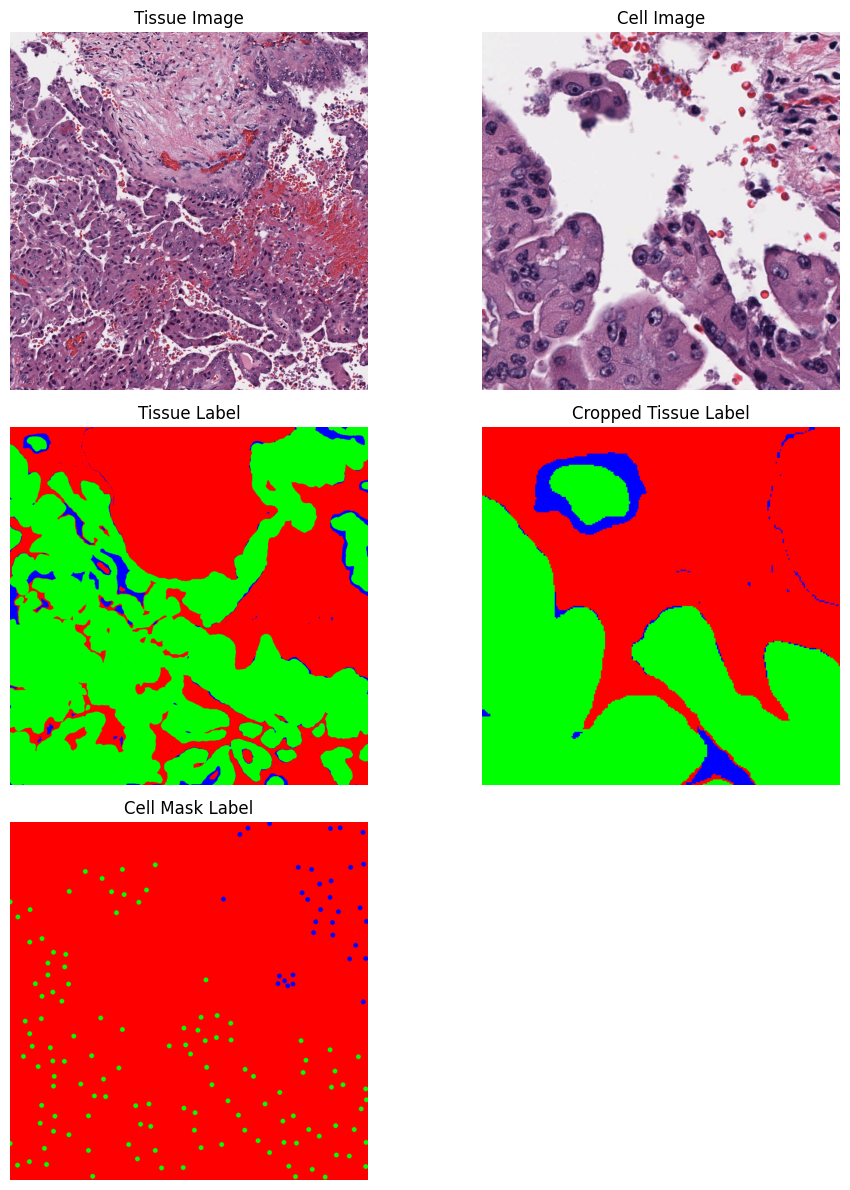

In [4]:
import matplotlib.pyplot as plt


def show_images_grid(
    img_tissue, label_tissue, img_cell, label_cell_mask, label_cropped_tissue
):
    """
    Display images in a 3-row x 2-column grid:
    - Row 1, Col 1: Tissue Image
    - Row 1, Col 2: Cell Image
    - Row 2, Col 1: Tissue Label
    - Row 2, Col 2: Cell Mask Label
    """

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

    images = [
        (img_tissue, "Tissue Image"),
        (img_cell, "Cell Image"),
        (label_tissue, "Tissue Label"),
        (label_cropped_tissue, "Cropped Tissue Label"),
        (label_cell_mask, "Cell Mask Label"),
    ]

    for i, (img, title) in enumerate(images):
        row = i // 2
        col = i % 2

        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            print(img.shape)
        # Normalize floating point images to [0,1] for visualization
        if img.dtype in [np.float32, np.float64] and img.max() > 1:
            img = img / 255.0

        cmap = "gray" if len(img.shape) == 2 else None

        axes[row, col].imshow(img, cmap=cmap)
        axes[row, col].set_title(title)
        axes[row, col].axis("off")

    for j in range(len(images), 6):  # Max is 6 subplots (3x2 grid)
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


load_image = LoadImage(image_only=True)

sample = train_files[number]  # Pick a sample

img_tissue = load_image(sample["img_tissue"])

label_tissue = load_image(sample["label_tissues"])
label_tissue[label_tissue == 255.0] = 3.0
label_tissue = label_tissue - 1
label_tissue = AsDiscrete(to_onehot=3)(label_tissue.unsqueeze(0)).permute(1, 2, 0)

img_cell = load_image(sample["img_cells"])
label_cell_mask = load_image(sample["label_cell_masks"])
label_cropped_tissue = load_image(sample["label_cropped_tissues"])
# label_cell = load_image(sample["label_cells"]) isnt of image format

# Display the images in a 3x2 grid
show_images_grid(
    img_tissue, label_tissue, img_cell, label_cell_mask, label_cropped_tissue
)

In [5]:
def standardize_label(label):
    """
    Standardize label_tissues to be in [0, 1] range.
    - If values are in [0, 255], normalize.
    - If values are categorical (e.g., {0,1,2}), leave as is.
    """
    if label.max() > 1:  # If the label has intensity values 0-255, normalize
        label = label / 255.0
    return label  # Keep as is if already normalized or categorical


def onehot_tissue_label(label):
    label[label > 2] = 3
    return T.AsDiscrete(to_onehot=3)(label - 1)


def exclude_bg(label):
    return label[1:, :, :]


default_preprocess = T.Compose(
    [
        T.LoadImaged(
            keys=[
                "img_tissue",
                "img_cells",
                "label_tissues",
                "label_cropped_tissues",
                "label_cell_masks",
            ]
        ),
        T.EnsureChannelFirstd(
            keys=[
                "img_tissue",
                "img_cells",
                "label_tissues",
                "label_cropped_tissues",
                "label_cell_masks",
            ]
        ),
        T.Lambdad(keys=["label_tissues"], func=onehot_tissue_label),
        T.Lambdad(
            keys=["label_tissues", "label_cropped_tissues", "label_cell_masks"],
            func=exclude_bg,
        ),
        # T.AsDiscreted(keys=["label_tissues"], to_onehot=2, threshold=0.5),
        T.NormalizeIntensityd(keys=["img_tissue", "img_cells"]),  # Normalize intensity
        T.ConcatItemsd(
            keys=["img_tissue", "img_cells"], name="image", dim=0
        ),  # Stack images as multi-channel input
        T.ConcatItemsd(
            keys=["label_tissues", "label_cropped_tissues", "label_cell_masks"],
            name="label",
            dim=0,
        ),  # Stack labels as multi-channel target
        T.ToTensord(keys=["image", "label"]),  # Convert to PyTorch tensors
    ]
)

In [6]:
augment = T.Compose(
    [
        T.RandZoomd(
            keys=["image", "label"], prob=0.7, min_zoom=0.9, max_zoom=1.1
        ),  # Zoom with ±10% resizing
        T.RandCropByLabelClassesd(
            keys=["image", "label"],
            label_key="label",
            spatial_size=[896, 896],
            num_classes=6,
            num_samples=1,
            ratios=[1, 1, 1, 1, 1, 1],
        ),  # Random crop to 896x896
        T.RandFlipd(
            keys=["image", "label"], prob=0.7, spatial_axis=[0, 1]
        ),  # Random flip (horizontal or vertical)
        T.RandRotate90d(
            keys=["image", "label"], prob=0.7
        ),  # Random rotation by 90°, 180°, or 270°
        T.RandAdjustContrastd(
            keys=["image"], prob=0.7, gamma=(0.8, 1.2)
        ),  # Random brightness and contrast adjustment
    ]
)

In [7]:
preprocessed = default_preprocess(train_files[:10])

In [8]:
print(f"Input Shape (Image): {preprocessed[0]['image'].shape}")
print(f"Target Shape (Label): {preprocessed[0]['label'].shape}")

Input Shape (Image): torch.Size([6, 1024, 1024])
Target Shape (Label): torch.Size([6, 1024, 1024])


In [9]:
train_transform = T.Compose([default_preprocess, augment])

In [10]:
final_training_data = train_transform(train_files[:10])

/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/monai/transforms/utils.py:668: UserWarning: no available indices of class 1 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/monai/transforms/utils.py:668: UserWarning: no available indices of class 3 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/monai/transforms/utils.py:668: UserWarning: no available indices of class 5 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/monai/transforms/utils.py:668: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


In [11]:
# Select a sample from transformed data
sample = final_training_data[number][0]

# Extract image and label tensors
image_tensor = sample["image"]
label_tensor = sample["label"]


image_np = image_tensor.cpu().numpy()
label_np = label_tensor.cpu().numpy()

# Print statistics
print(f"Image Shape: {image_np.shape}, Min: {image_np.min()}, Max: {image_np.max()}")
print(f"Label Shape: {label_np.shape}, Min: {label_np.min()}, Max: {label_np.max()}")

# Check value distributions per channel
for i in range(image_np.shape[0]):
    print(
        f"Image Channel {i}: Min={image_np[i].min()}, Max={image_np[i].max()}, Mean={image_np[i].mean()}"
    )

for j in range(label_np.shape[0]):
    print(
        f"Label Channel {j}: Min={label_np[j].min()}, Max={label_np[j].max()}, Mean={label_np[j].mean()}"
    )


Image Shape: (6, 896, 896), Min: -2.734342575073242, Max: 2.0093774795532227
Label Shape: (6, 896, 896), Min: 0.0, Max: 1.0
Image Channel 0: Min=-2.455488920211792, Max=2.0093774795532227, Mean=0.526567280292511
Image Channel 1: Min=-2.5345041751861572, Max=2.0093774795532227, Mean=-0.32486894726753235
Image Channel 2: Min=-2.35597562789917, Max=2.0093774795532227, Mean=0.31296706199645996
Image Channel 3: Min=-2.734342575073242, Max=1.455960750579834, Mean=0.367307186126709
Image Channel 4: Min=-2.734342575073242, Max=1.455960750579834, Mean=-0.08471138775348663
Image Channel 5: Min=-2.312450408935547, Max=1.455960750579834, Mean=0.34779372811317444
Label Channel 0: Min=0.0, Max=1.0, Mean=0.5464826226234436
Label Channel 1: Min=0.0, Max=1.0, Mean=0.024628307670354843
Label Channel 2: Min=0.0, Max=1.0, Mean=0.46179449558258057
Label Channel 3: Min=0.0, Max=1.0, Mean=0.04257015138864517
Label Channel 4: Min=0.0, Max=1.0, Mean=0.01715959794819355
Label Channel 5: Min=0.0, Max=1.0, Mean=0

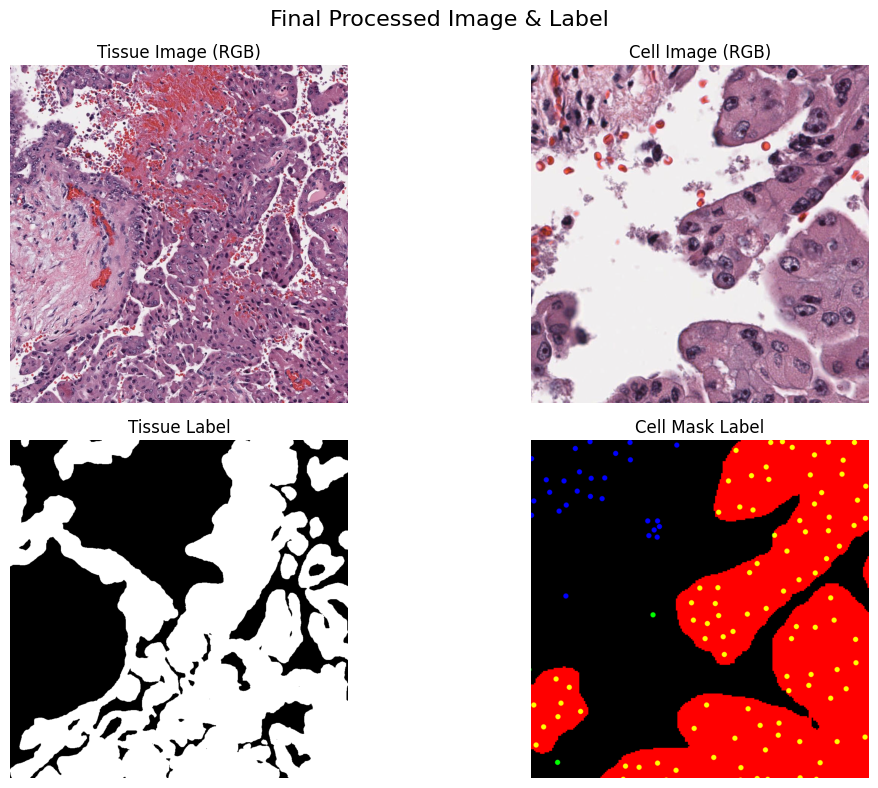

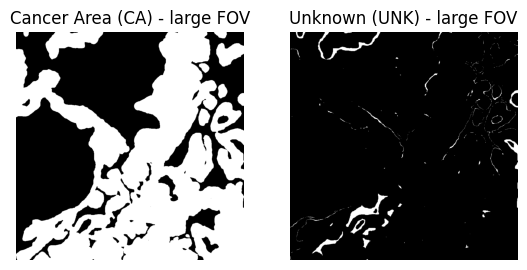

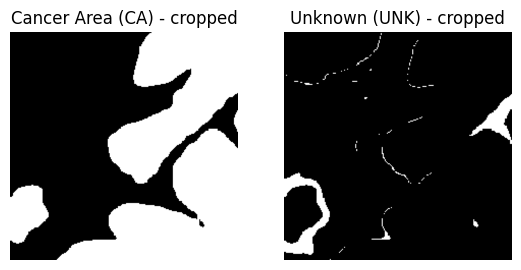

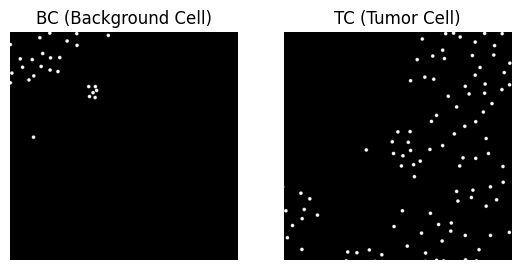

In [12]:
def show_preprocessed_sample(
    image_tensor, label_tensor, title="Preprocessed Image & Label Grid"
):
    """
    Display all channels of an image and corresponding labels in a structured grid.

    - The first 3 channels are displayed as "Tissue Image" (RGB)
    - The next 3 channels are displayed as "Cell Image" (RGB)
    - The tissue label is displayed in RGB if it has 3 channels, otherwise it's converted
    - The cell label is displayed as a grayscale mask

    Args:
        image_tensor (torch.Tensor or np.ndarray): Multi-channel image tensor (6, H, W)
        label_tensor (torch.Tensor or np.ndarray): Multi-channel label tensor (4, H, W)
    """
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()
    if isinstance(label_tensor, torch.Tensor):
        label_tensor = label_tensor.cpu().numpy()

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 Rows, 2 Cols

    # Normalize function for visualization
    def normalize(img):
        return (img - img.min()) / (img.max() - img.min()) if img.max() > 1 else img

    ## **🔹 Row 1: Visualize Images**
    # First 3 channels as RGB (Tissue Image)
    tissue_image = np.stack([normalize(image_tensor[i]) for i in range(3)], axis=-1)
    axes[0, 0].imshow(tissue_image)
    axes[0, 0].set_title("Tissue Image (RGB)")
    axes[0, 0].axis("off")

    # Next 3 channels as RGB (Cell Image)
    cell_image = np.stack([normalize(image_tensor[i]) for i in range(3, 6)], axis=-1)
    axes[0, 1].imshow(cell_image)
    axes[0, 1].set_title("Cell Image (RGB)")
    axes[0, 1].axis("off")

    # tissue_label = np.stack([normalize(label_tensor[i]) for i in range(0, 2)], axis=-1)
    axes[1, 0].imshow(label_tensor[0], cmap="gray")
    axes[1, 0].set_title("Tissue Label")
    axes[1, 0].axis("off")

    # Cell Mask Label
    cell_mask_label = np.stack([normalize(label_tensor[i]) for i in [2, 4, 5]], axis=-1)
    axes[1, 1].imshow(cell_mask_label)
    axes[1, 1].set_title("Cell Mask Label")
    axes[1, 1].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Visualize each channel to confirm label assignments
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(label_tensor[0], cmap="gray")
    plt.title("Cancer Area (CA) - large FOV")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label_tensor[1], cmap="gray")
    plt.title("Unknown (UNK) - large FOV")
    plt.axis("off")

    plt.show()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(label_tensor[2], cmap="gray")
    plt.title("Cancer Area (CA) - cropped")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label_tensor[3], cmap="gray")
    plt.title("Unknown (UNK) - cropped")
    plt.axis("off")

    plt.show()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(label_tensor[5], cmap="gray")
    plt.title("BC (Background Cell)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label_tensor[4], cmap="gray")
    plt.title("TC (Tumor Cell)")
    plt.axis("off")

    plt.show()


# Extract the processed image and label tensors
image_tensor = sample["image"]
label_tensor = sample["label"]

# Visualize the structured grid
show_preprocessed_sample(
    image_tensor, label_tensor, title="Final Processed Image & Label"
)